In [4]:
import paddle
import paddle.fluid as fluid
import paddle.fluid.dygraph as dygraph
from paddle.fluid.dygraph import Linear
from paddle.utils.plot import Ploter
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

2020-04-17 09:34:52,516-INFO: Could not open font file /usr/share/fonts/truetype/noto/NotoColorEmoji.ttf: In FT2Font: Could not set the fontsize
2020-04-17 09:34:52,922-INFO: generated new fontManager


In [5]:
fluid.dygraph.parallel.Env().dev_id

0

In [2]:
train = pd.read_csv('cache/daily.csv')

In [3]:
cols = ['days','discount', 'hd','avgprice', 'hao', 'ping', 'cha', 'hf','avghao', 'avgping', 'avgcha', 'avghf', 'pv', 'uv',
           'sc', 'jg', 'at', 'sh', 'WeeksAgoNum','twoWeeksAgoNum','num']

In [4]:
train = train[36:-2][cols].reset_index(drop=True)

In [5]:
maximums, minimums, avgs = train.max(axis=0), train.min(axis=0), \
                                 train.sum(axis=0) / train.shape[0]

In [6]:
train_x = train.apply(lambda x: (x - np.mean(x, axis=0) / (np.max(x) - np.min(x))))

In [7]:
train_len = int(len(train_x) * 0.8)

In [8]:
training_data = train_x[5:train_len].copy().reset_index(drop=True).values
test_data = train_x[train_len:].copy().reset_index(drop=True).values

In [9]:
def my_train_reader():
    def reader():
        for temp in training_data:
            yield temp[:-1], temp[-1]
    return reader
 
def my_test_reader():
    def reader():
        for temp in test_data:
            yield temp[:-1], temp[-1]    
    return reader

In [10]:
train_reader = paddle.batch(my_train_reader(),batch_size=1000)

In [11]:
DIM = 1
hid_dim2 = 1
#lod_level=0表示0 means the input data is not a sequence
x = fluid.layers.data(name='x', shape=[DIM], dtype='float32', lod_level=1)
label = fluid.layers.data(name='y', shape=[1], dtype='float32')

In [12]:
# Lstm layer
fc0 = fluid.layers.fc(input=x, size=DIM * 4)
lstm_h, c = fluid.layers.dynamic_lstm(input=fc0, size=DIM * 4, is_reverse=False)
# 最大池化
lstm_max = fluid.layers.sequence_pool(input=lstm_h, pool_type='max')
# 激活函数
lstm_max_tanh = fluid.layers.tanh(lstm_max)
# 全连接层
prediction = fluid.layers.fc(input=lstm_max_tanh, size=hid_dim2, act='tanh')
# 代价函数
cost = fluid.layers.square_error_cost(input=prediction, label=label)
avg_cost = fluid.layers.mean(x=cost)

In [13]:
train_title = "Train cost"
test_title = "Test cost"
plot_cost = Ploter(train_title, test_title)

In [14]:
adam_optimizer = fluid.optimizer.Adam(learning_rate=0.001)
adam_optimizer.minimize(avg_cost)
 
# 使用CPU
place = fluid.CPUPlace()
# place = fluid.CUDAPlace(1)
 
exe = fluid.Executor(place)#Python中的一个执行器，只支持单个GPU运行。
exe.run(fluid.default_startup_program())#获取默认/全局启动程序,并由执行器执行
 
feeder = fluid.DataFeeder(place=place, feed_list=[x, label])

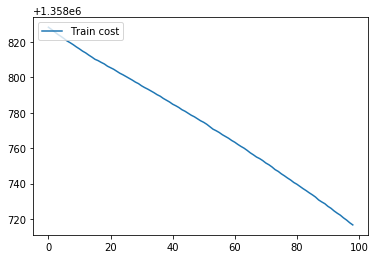

In [ ]:
step = 0 # 画图用
PASS_NUM = 100
for pass_id in range(PASS_NUM):
    total_loss_pass = 0#初始化每一个epoch的损失值初始值为0
    for data in train_reader(): #data表示batch大小的数据样本          
        avg_loss_value, = exe.run(
            fluid.default_main_program(), 
            feed= feeder.feed(data), 
            fetch_list=[avg_cost])
        total_loss_pass += avg_loss_value#计算每个epoch的总损失值
    print("Pass %d, total avg cost = %f" % (pass_id, total_loss_pass))
#     画图
    plot_cost.append(train_title, step, avg_loss_value)
    step += 1
    plot_cost.plot()
fluid.io.save_inference_model('model', ['x'], [prediction], exe)

In [ ]:
def convert2LODTensor(temp_arr, len_list):
    temp_arr = np.array(temp_arr).astype('float32')
    temp_arr = temp_arr.flatten().reshape((-1, 1))#把325个测试样本的array平坦化到一维数据[1950,1]的格式
    print(temp_arr.shape)
    return fluid.create_lod_tensor(
        data=temp_arr,#对测试样本来说这里表示325个样本的平坦化数据列表，维度为[1950,1]
        recursive_seq_lens =[len_list],#对于测试样本来说这里全是6，所以为325 个6的列表
        place=place
        )#返回：A fluid LoDTensor object with tensor data and recursive_seq_lens info

def get_tensor_label(mini_batch):  
    tensor = None
    labels = []    
    temp_arr = []
    len_list = []
    for _ in mini_batch:   #mini_batch表示的大小为325个测试样本数据
        labels.append(_[1]) #收集 label----y----------1维
        temp_arr.append(_[0]) #收集序列本身--x---------6维
        len_list.append(len(_[0])) #收集每个序列x的长度,和上边x的维度对应，这里全为6
    tensor = convert2LODTensor(temp_arr, len_list)    
    return tensor, labels
 
my_tensor = None
labels = None
 
# 定义batch
test_reader = paddle.batch(
    my_test_reader(),
    batch_size=500)#一次性把样本取完

for mini_batch in test_reader():
    my_tensor,labels = get_tensor_label(mini_batch)#其实就是变成tensor格式的x和y
    break

In [ ]:
inference_scope = fluid.core.Scope()
fluid.scope_guard(inference_scope)

In [ ]:
[inference_program, feed_target_names, fetch_targets] = (fluid.io.load_inference_model("model", exe))

In [ ]:
results = exe.run(inference_program,feed= {'x':my_tensor},fetch_list=fetch_targets)

In [ ]:
with fluid.scope_guard(inference_scope):
    [inference_program, feed_target_names, fetch_targets] = (fluid.io.load_inference_model("model", exe))
    print(feed_target_names)
    results = exe.run(inference_program,feed= {'x':my_tensor},fetch_list=fetch_targets)
    result_print = results[0].flatten()
    plt.figure()
#     plt.plot(list(range(len(labels))), labels, color='r')  #红线为真实值
    plt.plot(list(range(len(result_print))), result_print, color='g')  #绿线为预测值
    plt.show()